## GRU-RNN Time Series Prediction Bitcoin

### 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data-frame
import pandas as pd
from pandas import concat
from pandas import read_csv
from pandas import read_excel
from pandas_datareader import DataReader

# pustaka untuk madnipulasi data-array
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pustaka untuk  evaluasi model prediksi
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
# tf.random.set_seed(7)
# tf.keras.utils.set_random_seed(7)

In [4]:
tf.random.set_seed(42)

In [5]:
# membaca dataset via csv file
dataset = read_csv("dataset/BTC-USD.csv", parse_dates=['Date']);

In [6]:
# set index tanggal
dataset = dataset.set_index("Date");

In [7]:
# menampilkan metadata dataset
dataset.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2014-12-09 to 2022-11-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2896 non-null   float64
 1   High       2896 non-null   float64
 2   Low        2896 non-null   float64
 3   Close      2896 non-null   float64
 4   Adj Close  2896 non-null   float64
 5   Volume     2896 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 158.4 KB


In [8]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-09,361.894989,363.066986,344.950989,352.218994,352.218994,32915500
2014-12-10,352.204987,352.384003,346.364990,346.364990,346.364990,16427700
2014-12-11,344.339996,361.356995,338.763000,350.506012,350.506012,32431300
2014-12-12,350.833008,352.983002,349.290985,352.541992,352.541992,16989800
2014-12-13,352.381012,352.381012,346.588013,347.376007,347.376007,11675900
...,...,...,...,...,...,...
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,18541.271484,118992465607
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,15880.780273,102905151606
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,17586.771484,83202283721


### 3. Eksplorasi Datsa Analisis

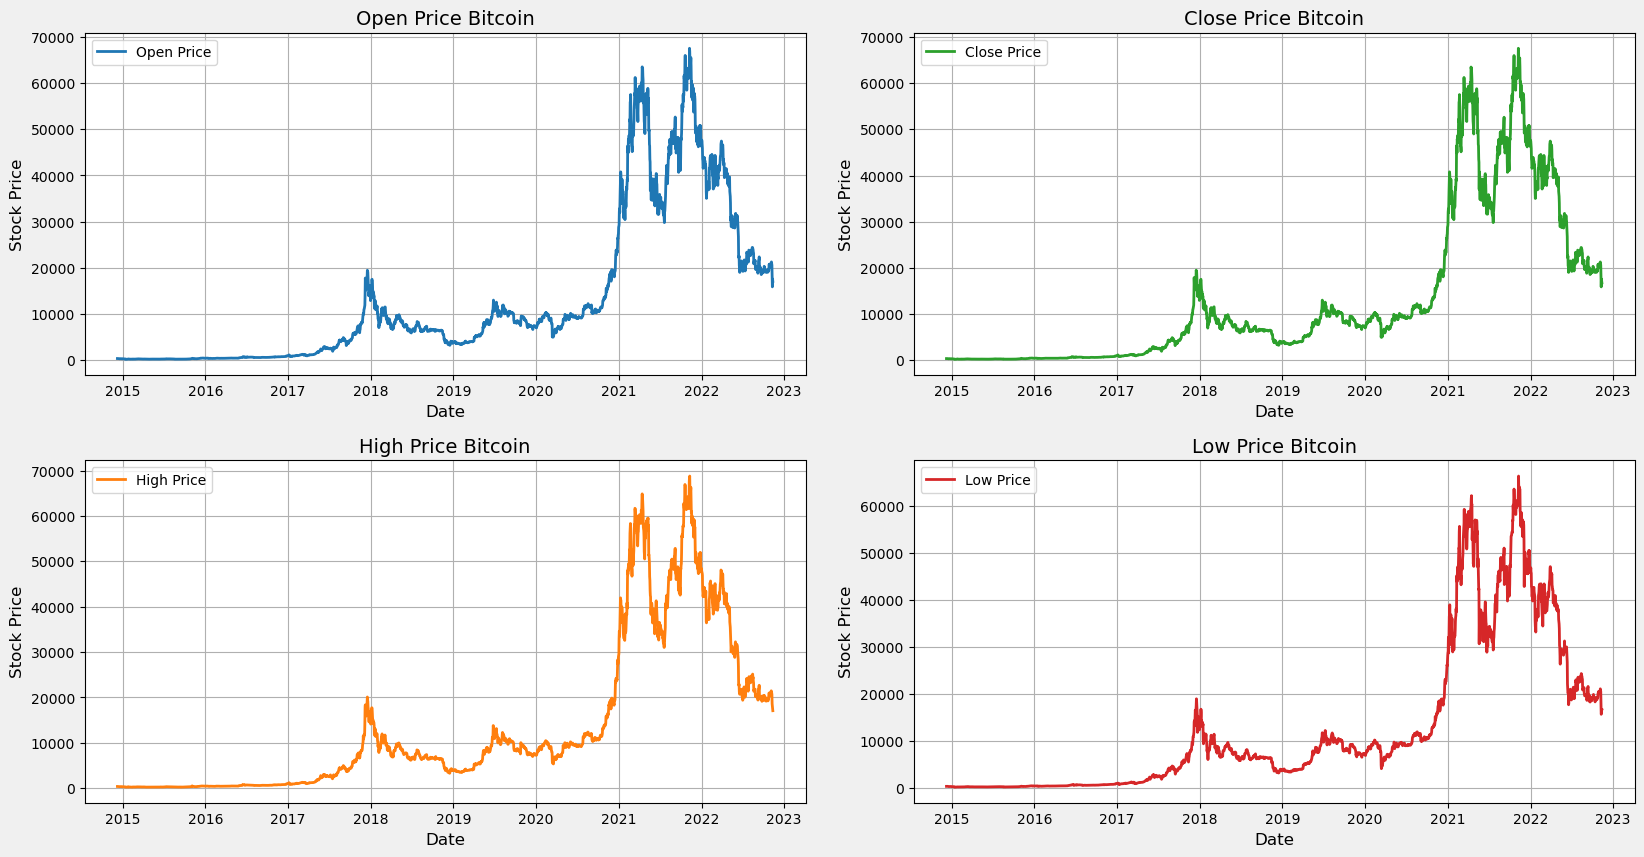

In [9]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price", linewidth=2)

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price", linewidth=2)

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price", linewidth=2)

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price", linewidth=2)

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

### 4. Praproses Dataset

- Seleksi Fitur

In [10]:
# memilih fitur close price
dataset = dataset.filter(['Close']);

In [11]:
# convert dataframe to series close price
data = dataset.values

In [12]:
np.round(data[:5],7)

array([[352.218994],
       [346.36499 ],
       [350.506012],
       [352.541992],
       [347.376007]])

- Normalisasi Data

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [14]:
np.round(scaled_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [15]:
scaled_data.shape

(2896, 1)

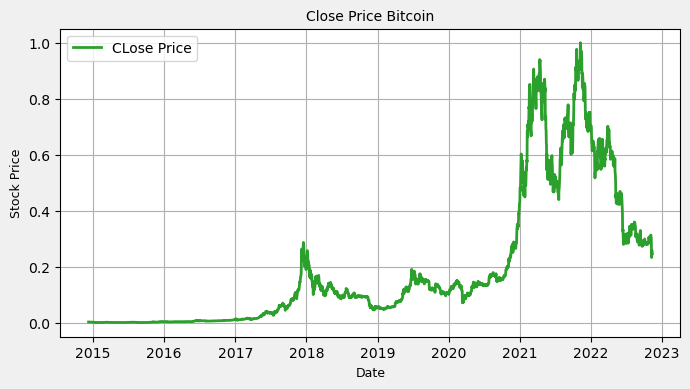

In [16]:
# membuat frame
fig, ax = plt.subplots(facecolor="#f0f0f0", figsize=(8,4))

# membuat time series plot
ax.plot(dataset.index.values, scaled_data, color="tab:green", label="CLose Price", linewidth=2)

# membuat label-label
ax.set_title("Close Price Bitcoin", fontsize=10)
ax.set_xlabel("Date", fontsize=9)
ax.set_ylabel("Stock Price", fontsize=9)
ax.legend(loc='upper left')
ax.grid(True)

# menampilkan plot
plt.show()

- Data latih dan Data uji

In [17]:
# set data train
train_size = math.ceil(len(dataset)*0.8)
train_data = scaled_data[0:train_size , :]

In [18]:
np.round(train_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [19]:
train_data.shape

(2317, 1)

In [20]:
# set data test
test_size = len(dataset) - train_size
test_data = scaled_data[train_size:len(dataset) , :]

In [21]:
np.round(test_data[:5],7)

array([[0.9397025],
       [0.9338594],
       [0.9368913],
       [0.9110528],
       [0.8978611]])

In [22]:
test_data.shape

(579, 1)

- Supervised Learning

In [23]:
# convert an array of values into a dataset matrix

# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [24]:
# process supervised learning
look_back = 60
x_train, y_train = create_dataset(look_back, train_data)
x_test, y_test = create_dataset(look_back, test_data)

In [25]:
print(x_train.shape, y_train.shape)

(2257, 60) (2257,)


In [26]:
print(x_test.shape, y_test.shape)

(519, 60) (519,)


In [27]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
print(x_train.shape, x_test.shape)

(2257, 60, 1) (519, 60, 1)


### 5. Modeling GRU-RNN

In [29]:
# The GRU architecture
model = Sequential()

# First GRU layer with Dropout regularisation
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))

# Second GRU layer with Dropout regularisation
model.add(GRU(50, return_sequences=False))
# model.add(Dropout(0.2))

# Third GRU layer with Dropout regularisation
# model.add(GRU(50, return_sequences=False))
# model.add(Dropout(0.2))

# # Fourty GRU layer with Dropout regularisation
# model.add(GRU(50, return_sequences=False))
# model.add(Dropout(0.2))

# The output layer
model.add(Dense(1))

# Compile the model GRU
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
283/283 [==============================] - 9s 22ms/step - loss: 6.9180e-04
Epoch 2/50
283/283 [==============================] - 6s 22ms/step - loss: 0.0032
Epoch 3/50
283/283 [==============================] - 6s 22ms/step - loss: 0.0043
Epoch 4/50
283/283 [==============================] - 6s 22ms/step - loss: 0.0031
Epoch 5/50
283/283 [==============================] - 6s 21ms/step - loss: 0.0028
Epoch 6/50
283/283 [==============================] - 6s 22ms/step - loss: 0.0026
Epoch 7/50
283/283 [==============================] - 7s 23ms/step - loss: 0.0021
Epoch 8/50
283/283 [==============================] - 6s 22ms/step - loss: 0.0015
Epoch 9/50
283/283 [==============================] - 6s 22ms/step - loss: 7.3901e-04
Epoch 10/50
283/283 [==============================] - 6s 22ms/step - loss: 2.1133e-04
Epoch 11/50
283/283 [==============================] - 6s 22ms/step - loss: 9.0045e-05
Epoch 12/50
283/283 [==============================] - 6s 22ms/step - loss: 9.26

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [32]:
predictions = model.predict(x_test)

17/17 [==============================] - 1s 6ms/step


In [33]:
print(predictions[:7])

[[0.573293  ]
 [0.5458123 ]
 [0.60020024]
 [0.61778396]
 [0.61953723]
 [0.5873781 ]
 [0.5832288 ]]


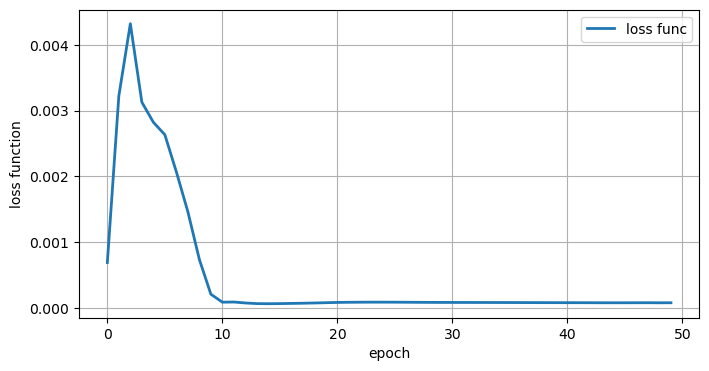

In [34]:
# membuat frame
fig, ax = plt.subplots(figsize = (8,4))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="loss func", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### 6. Evaluasi Model GRU-RNN

In [35]:
scores = model.evaluate(x_train, y_train)
scores

71/71 [==============================] - 1s 6ms/step - loss: 2.2242e-04


0.00022241623082663864

In [36]:
scores = model.evaluate(x_test, y_test)
scores

17/17 [==============================] - 0s 6ms/step - loss: 7.5994e-04


0.0007599388482049108

- MAE (Mean Absolute Error)

In [37]:
mae = mean_absolute_error(y_test, predictions)
print('Test MAE : %.4f' % mae)

Test MAE : 0.0224


- MSE (Mean Squared Error)

In [38]:
mse = mean_squared_error(y_test, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0008


- RMSE (Root Mean Squared Error)

In [39]:
rmse = sqrt(mse)
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0276


- Corelation pearson

In [40]:
hasil = np.stack((y_test.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,0.524931,0.573293
1,0.577541,0.545812
2,0.594170,0.600200
3,0.596957,0.617784
4,0.566400,0.619537


In [41]:
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.9944 dengan signifikansi 0.0000 


- Complexity time

In [42]:
# Set akhir waktu komputasi 
end = time.time()

In [43]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [44]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:05:22.99


### 8. Visualisasi Data

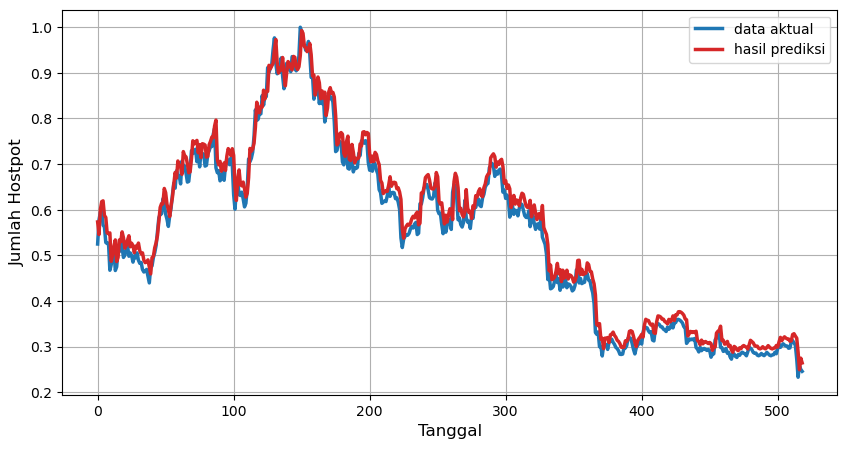

In [45]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
# ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

### 9. Inverse Value Max-Min

- predic model lstm

In [46]:
train_predictions = model.predict(x_train)

71/71 [==============================] - 0s 6ms/step


In [47]:
test_predictions = model.predict(x_test)

17/17 [==============================] - 0s 6ms/step


- inverse to original dataset

In [48]:
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))

In [49]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

- inverse result predic to original data

In [50]:
train_predictions_inv = scaler.inverse_transform(train_predictions)

In [51]:
test_predictions_inv = scaler.inverse_transform(test_predictions)

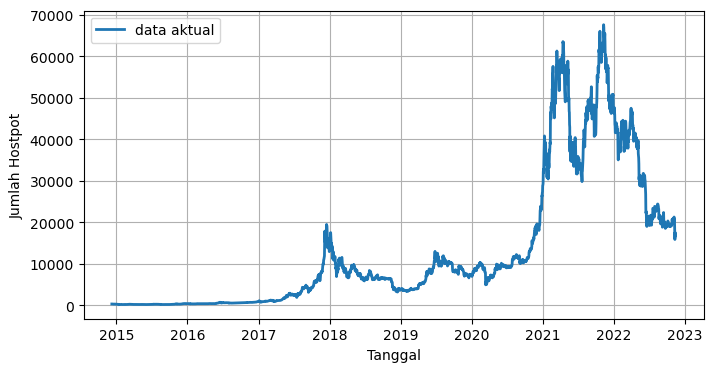

In [52]:
# generate urutan data sesuai panjang datanya

# membuat frame
fig, ax = plt.subplots(figsize = (8,4))

# membuat time series plot
ax.plot(dataset.index.values, dataset["Close"], color="tab:blue", label="data aktual", linewidth=2)

# membuat label-label
# ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Jumlah Hostpot")
ax.legend(loc='best')
ax.grid(True)

# menampilkan plot
plt.show()